In [1]:
from buffers import MultiEnvReplayBuffer
from bnn import BNN
from lion_opt import Lion
from planner_module_v3 import Planner
from metaworld.envs import (ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE)
import numpy as np
import matplotlib.pyplot as plt
import torchbnn as bnn
import torch.nn as nn
import torch
import pickle
import json
import random
import os
import tqdm 

''' 
This main is project for run with the MetaWorld benchmark suite, 
for any migration to new benchmark, modify the bnn structure
'''

# for maximum compatibility with numpy array
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [3]:
def update_with_elbo(net, buffer, optimizer, task_id):
    states, actions, rewards, next_states, dones = buffer.sample_all_envs(batch_size=BATCH_SIZE) if (
                task_id == -1) else buffer.sample_env(task_id, batch_size=BATCH_SIZE)

    optimizer.zero_grad()
    x = torch.Tensor(np.concatenate((states, actions), axis=-1)).to(DEVICE)
    y_true = torch.Tensor(np.concatenate((next_states, rewards), axis=-1)).to(DEVICE)
    y_pred = net(x)

    mse = mse_loss(y_pred, y_true)
    kl = kl_loss(net)
    loss = mse + KL_WEIGHT * kl
    loss.backward()
    optimizer.step()
    return mse.item(), kl.item(), loss.item()


In [4]:

def save_json_update(json_obj):
    with open('config_parameters.json', 'w') as f:
        json.dump(json_obj, f)


def json_load():
    with open('config_parameters.json', 'r') as f:
        config_file = json.load(f)
    return config_file


def save_torch_models(models: dict, path,):
    for k, model in models.items():
        name = os.path.join(path, f'model_env{k}.pth')
        torch.save(model.state_dict(), name)


def save_binary_objs(objs, path, name_template: str):
    for k, obj in objs.items():
        name = os.path.join(path, name_template+f'{k}.pkl')
        with open(name, 'wb') as f:
            pickle.dump(obj, f)


def load_binary_file(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj



In [5]:
config = json_load()

# nested struct
buff_config = config['buffer']
train_config =  config['train']
const_config = config['const']

DEVICE = const_config['DEVICE']
BATCH_SIZE = train_config['BATCH_SIZE']
KL_WEIGHT = 0.0001

multibuffer = MultiEnvReplayBuffer(
        buffer_size_per_env=buff_config['max_size_for_env']
    )
    # ----- load automatically all the buffer ------
if buff_config['preload']:
    multibuffer.read_buffers(buff_config['IO_option']['path'],
                             buff_config['IO_option']['from_scratch']
                             )


old buffer to load: name: ['buffer_env43.pkl', 'buffer_env29.pkl', 'buffer_env40.pkl', 'buffer_env10.pkl', 'buffer_env49.pkl', 'buffer_env19.pkl', 'buffer_env45.pkl', 'buffer_env35.pkl', 'buffer_env50.pkl', 'buffer_env06.pkl', 'buffer_env18.pkl', 'buffer_env07.pkl', 'buffer_env12.pkl', 'buffer_env00.pkl', 'buffer_env36.pkl', 'buffer_env05.pkl', 'buffer_env30.pkl', 'buffer_env37.pkl', 'buffer_env14.pkl', 'buffer_env38.pkl', 'buffer_env24.pkl', 'buffer_env17.pkl', 'buffer_env44.pkl', 'buffer_env27.pkl', 'buffer_env03.pkl', 'buffer_env02.pkl']
processing buffer path : buffer_stock/buffer_env43.pkl
processing buffer path : buffer_stock/buffer_env29.pkl
processing buffer path : buffer_stock/buffer_env40.pkl
processing buffer path : buffer_stock/buffer_env10.pkl
processing buffer path : buffer_stock/buffer_env49.pkl
processing buffer path : buffer_stock/buffer_env19.pkl
processing buffer path : buffer_stock/buffer_env45.pkl
processing buffer path : buffer_stock/buffer_env35.pkl
processing bu

In [10]:
world_model = BNN(action_dim=const_config['ACTION_SHAPE'],
                      obs_dim=const_config['OBS_SHAPE'],
                      reward_dim=const_config['REWARD_SHAPE']
                      ).to(DEVICE)
#world_model.load_state_dict(torch.load('model_stock/world/model_envWorld.pth'))

outer_opt = Lion(world_model.parameters(), lr=1e-5)
mse_loss = nn.MSELoss().to(DEVICE)
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(DEVICE)
   

In [11]:

losses_mse = []
losses_kl = []
total_loss = []


losses_kl_partial = []
losses_mse_partial = []
total_loss_partial = []


In [40]:


iteration = 10000
for i in tqdm.tqdm(range(iteration)):

    loss = update_with_elbo(world_model, multibuffer, optimizer=outer_opt, task_id=-1)
    losses_mse_partial.append(loss[0])
    losses_kl_partial.append(loss[1])
    total_loss_partial.append(loss[2])

    if i%10 == 0:
        losses_mse.append(sum(losses_mse_partial)/10)
        losses_kl.append(sum(losses_kl_partial)/10)
        total_loss.append(sum(total_loss_partial)/10)
        
        losses_kl_partial = []
        losses_mse_partial = []
        total_loss_partial = []

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 266.71it/s]


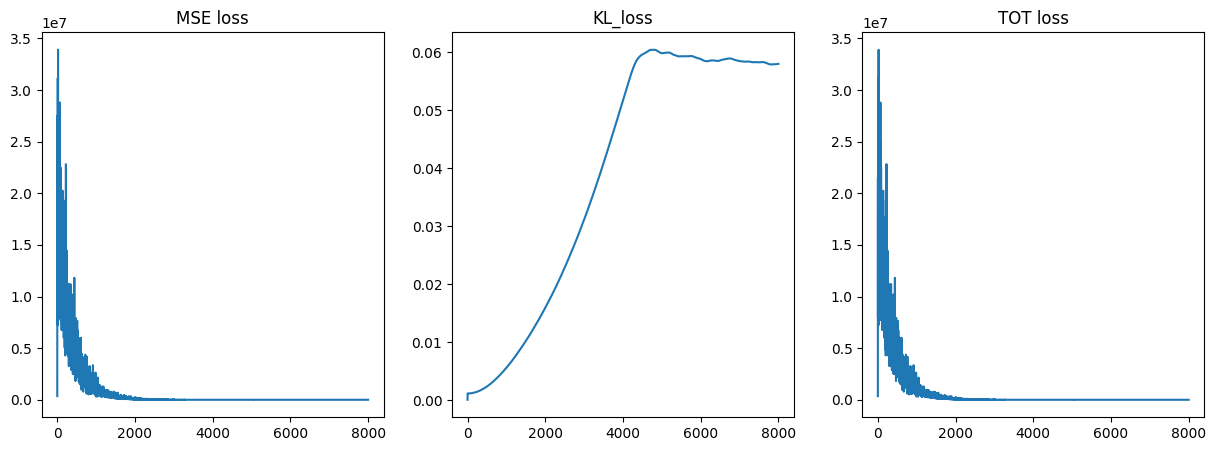

In [42]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(losses_mse), axes[0].set_title('MSE loss')
axes[1].plot(losses_kl), axes[1].set_title('KL_loss')
axes[2].plot(total_loss), axes[2].set_title('TOT loss')

plt.show()

In [87]:
save_torch_models({f'World_small_kl_checkpoint{len(total_loss*10)}': world_model}, train_config['path_world_model'])

In [86]:
s, a, r, ns, d  = multibuffer.sample_env(0, 1)
X = torch.concat([torch.from_numpy(s).reshape(-1), torch.from_numpy(a).reshape(-1)]).to(DEVICE)
world_model(X)

tensor([ 0.5480,  0.8174, -0.1775,  1.2501, -0.3675,  0.0504,  0.2276,  0.6093,
        -1.4444,  0.0358, -0.1196,  0.4294,  0.5241, -0.0062,  0.2592,  0.4730,
        -0.0873,  0.1103,  0.7002,  0.1524,  0.1167,  1.0761,  0.6251,  0.0847,
         0.3588,  0.4615,  0.8163, -0.7078,  0.2649,  0.4801,  1.0594,  0.3669,
        -1.3374, -1.1564, -0.7548,  0.3235, -0.0414, -0.0427,  1.2769, -0.1660],
       device='cuda:0', grad_fn=<AddBackward0>)